In [2]:
from platform import python_version

print(python_version())

3.7.4


In [3]:
import sys
# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('./secrets.py')

import logging
import math
import os

from influxdb import DataFrameClient
import numpy as np
import matplotlib.mlab as mlab
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
%matplotlib inline

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Need to ssh tunnel for this to work
# ssh -L 8086:localhost:8086 aq.byu.edu -N
influx = DataFrameClient(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD,
    database=DATABASE,
)


def large_query(influx, measurement, query, total=None, limit=100_000):
    if total is not None:
        total = math.ceil(total / limit)

    with tqdm(total=total) as pbar:
        offset = 0
        while True:
            new_query = query + " LIMIT {} OFFSET {}".format(limit, offset)
            data = influx.query(new_query)
            data = data[measurement]

            received = len(data)
            pbar.update(1)

            yield data

            offset += limit
            if received != limit:
                break


def load_data(filename):
    if os.path.exists(filename):
        LOGGER.info("Loading cached data...")
        return pd.read_hdf(filename)

    LOGGER.info("Downloading data...")
    result = influx.query(
        "SELECT COUNT(sequence) FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()"
    )
    count = result["air_quality_sensor"].values[0][0]

    queries = large_query(
        influx,
        "air_quality_sensor",
        "SELECT * FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()",
        count,
    )

    all_data = pd.concat(list(queries), sort=False)
    all_data.to_hdf(filename, "data")
    return all_data


data = load_data("aq_data.h5")
gold_data = load_data("aq_data.h5")

LOGGER.info("Done loading data...")



INFO:__main__:Loading cached data...
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:__main__:Loading cached data...
INFO:__main__:Done loading data...


2019-11-04 08:00:02+08:00
2019-11-04 08:00:02+08:00
All Sensors names: ['GA', 'ND', 'NE']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
All Heater Only Modified Gers list size: 554153
whiskers:  [0.0, 438.0]
caps:  [0.0, 438.0]
boxes:  [18.0]
medians:  [76.0]
means:  [138.67418023542234]
fliers:  []


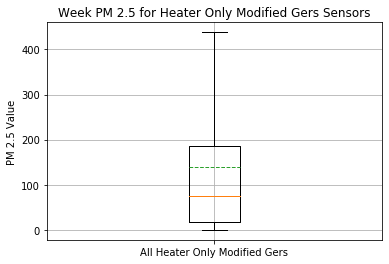

In [7]:
# all_heater_only_modified_gers - This is the working boxplot for all_heater_only_modified_gers only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['All Heater Only Modified Gers']
plt.xlabel('')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for Heater Only Modified Gers Sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']
data = data[data.pm2_5 >= 0]
data = data[data.location_name == 'Mongolia']
heater_only_modified_gers = ['GA', 'ND', 'NE']
data = data[(data.name == heater_only_modified_gers[0]) | (data.name == heater_only_modified_gers[1]) | (data.name == heater_only_modified_gers[2])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])

all_heater_only_modified_gers = [data['pm2_5']]
print('{} list size: {}'.format(labels[0], len(data['pm2_5'])))
results = plt.boxplot(all_heater_only_modified_gers, showfliers=False, labels=labels, showmeans=True, meanline=True)

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

2019-11-04 08:00:02+08:00
2019-11-04 08:00:02+08:00
All Sensors names: ['GA', 'ND', 'NE']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
Mon list size: 76734
Tue list size: 76721
Wed list size: 79860
Thu list size: 78824
Fri list size: 80935
Sat list size: 81178
Sun list size: 79901
total for all days: 554153

whiskers:  [1.0, 435.0, 0.0, 445.0, 0.0, 436.0, 0.0, 436.0, 0.0, 439.0, 0.0, 434.0, 0.0, 440.0]
caps:  [1.0, 435.0, 0.0, 445.0, 0.0, 436.0, 0.0, 436.0, 0.0, 439.0, 0.0, 434.0, 0.0, 440.0]
boxes:  [18.0, 15.0, 14.0, 19.0, 19.0, 19.0, 20.0]
medians:  [71.0, 64.0, 62.0, 93.0, 76.0, 78.5, 82.0]
means:  [151.97070399040842, 126.60706977229181, 140.4407838717756, 143.9046990764234, 116.52343238401185, 151.5146345068861, 139.95754746498793]
fliers:  []


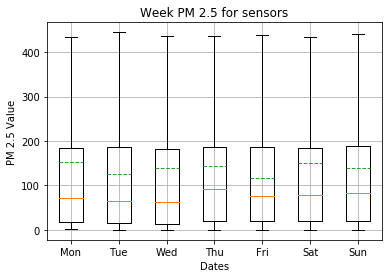

In [8]:
# Day - This is the working boxplot for hybrid only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']
data = data[data.pm2_5 >= 0]
data = data[data.location_name == 'Mongolia']
heater_only_modified_gers = ['GA', 'ND', 'NE']
data = data[(data.name == heater_only_modified_gers[0]) | (data.name == heater_only_modified_gers[1]) | (data.name == heater_only_modified_gers[2])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])

monday = data[(data.index.day_name() == 'Monday')]['pm2_5']
tuesday = data[data.index.day_name() == 'Tuesday']['pm2_5']
wednesday = data[data.index.day_name() == 'Wednesday']['pm2_5']
thursday = data[data.index.day_name() == 'Thursday']['pm2_5']
friday = data[data.index.day_name() == 'Friday']['pm2_5']
saturday = data[data.index.day_name() == 'Saturday']['pm2_5']
sunday = data[data.index.day_name() == 'Sunday']['pm2_5']
all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)

i = 0
cumulative = 0
for day in all_days:
    print('{} list size: {}'.format(labels[i], len(day)))
    cumulative += len(day)
    i+= 1
print('total for all days: {}'.format(cumulative))
print()

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

2019-11-04 08:00:02+08:00
2019-11-04 08:00:02+08:00
All Sensors names: ['GA', 'ND', 'NE']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
Monday - GA list size: 17136
Monday - ND list size: 29682
Monday - NE list size: 29916
Monday total: 76734

whiskers:  [1.0, 98.0, 1.0, 141.0, 163.0, 247.0]
caps:  [1.0, 98.0, 1.0, 141.0, 163.0, 247.0]
boxes:  [13.0, 9.0, 177.0]
medians:  [27.0, 23.0, 186.0]
means:  [40.904820261437905, 169.66872178424634, 198.03008423586041]
fliers:  []


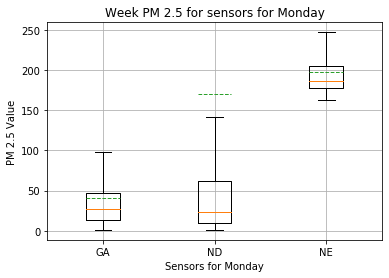

Tuesday - GA list size: 15943
Tuesday - ND list size: 30674
Tuesday - NE list size: 30104
Tuesday total: 76721

whiskers:  [0.0, 89.0, 0.0, 108.0, 164.0, 273.0]
caps:  [0.0, 89.0, 0.0, 108.0, 164.0, 273.0]
boxes:  [9.0, 8.0, 178.0]
medians:  [19.0, 22.0, 191.0]
means:  [38.14100232076773, 81.8811045184847, 219.03129152272123]
fliers:  []


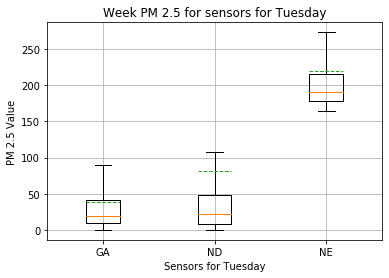

Wednesday - GA list size: 15778
Wednesday - ND list size: 32723
Wednesday - NE list size: 31359
Wednesday total: 79860

whiskers:  [0.0, 81.0, 0.0, 113.0, 127.0, 255.0]
caps:  [0.0, 81.0, 0.0, 113.0, 127.0, 255.0]
boxes:  [9.0, 7.0, 175.0]
medians:  [18.0, 20.0, 185.0]
means:  [30.60039295221194, 136.11912110747792, 200.21563187601646]
fliers:  []


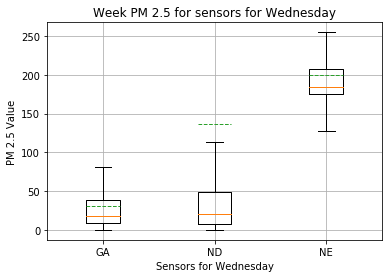

Thursday - GA list size: 14383
Thursday - ND list size: 32377
Thursday - NE list size: 32064
Thursday total: 78824

whiskers:  [0.0, 136.0, 0.0, 156.0, 162.0, 259.0]
caps:  [0.0, 136.0, 0.0, 156.0, 162.0, 259.0]
boxes:  [11.0, 9.0, 177.0]
medians:  [26.0, 24.0, 187.0]
means:  [49.38510741848015, 126.7230132501467, 203.6529129241517]
fliers:  []


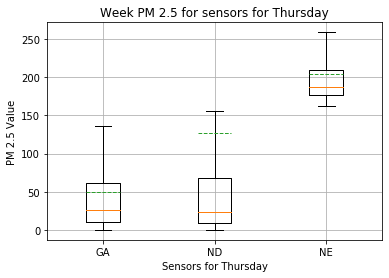

Friday - GA list size: 15050
Friday - ND list size: 32829
Friday - NE list size: 33056
Friday total: 80935

whiskers:  [1.0, 103.0, 0.0, 119.0, 154.0, 258.0]
caps:  [1.0, 103.0, 0.0, 119.0, 154.0, 258.0]
boxes:  [13.0, 9.0, 178.0]
medians:  [27.0, 21.0, 189.0]
means:  [41.2912292358804, 64.84598982606842, 202.09831800580832]
fliers:  []


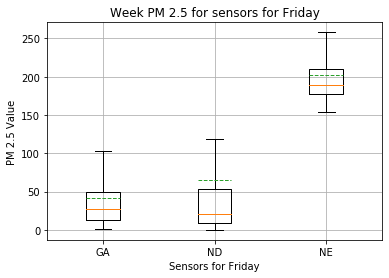

Saturday - GA list size: 15483
Saturday - ND list size: 33034
Saturday - NE list size: 32661
Saturday total: 81178

whiskers:  [0.0, 106.0, 0.0, 134.0, 159.0, 244.0]
caps:  [0.0, 106.0, 0.0, 134.0, 159.0, 244.0]
boxes:  [11.0, 9.0, 177.0]
medians:  [28.0, 23.0, 187.0]
means:  [42.78854227216948, 152.3470969304353, 202.21444536297113]
fliers:  []


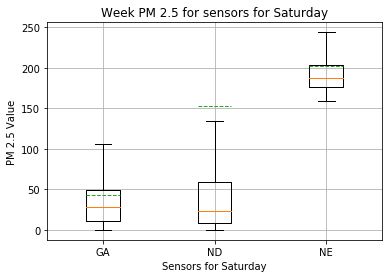

Sunday - GA list size: 16253
Sunday - ND list size: 31733
Sunday - NE list size: 31915
Sunday total: 79901

whiskers:  [1.0, 142.0, 0.0, 118.0, 150.0, 256.0]
caps:  [1.0, 142.0, 0.0, 118.0, 150.0, 256.0]
boxes:  [15.0, 8.0, 179.0]
medians:  [35.0, 22.0, 191.0]
means:  [72.28874669291822, 109.45306148173826, 204.74902083659723]
fliers:  []


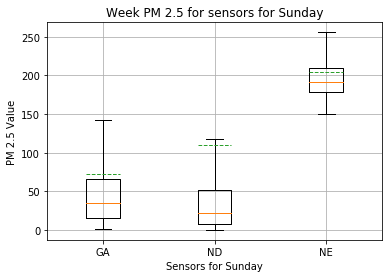

In [5]:
# Day each sensors - This is the working boxplot for hybrid only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html
import numpy as np
from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
plt.xlabel('Sensors')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data = data[data.pm2_5 >= 0]
data = data[data.location_name == 'Mongolia']
heater_only_modified_gers = ['GA', 'ND', 'NE']
data = data[(data.name == heater_only_modified_gers[0]) | (data.name == heater_only_modified_gers[1]) | (data.name == heater_only_modified_gers[2])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])


# for name, sensor_data in data.groupby("name"):
for day in days_of_week:
    plt.xlabel('Sensors for {0}'.format(day))
    plt.ylabel('PM 2.5 Value')
    plt.title('Week PM 2.5 for sensors for {0}'.format(day))
    plt.grid(True)
    sensors_data = list()
    sensors_name = list()
    temp = data[data.index.day_name() == day]
    # temp = temp.groupby("name")
    cumulative = 0    
    for name, sensor_data in temp.groupby("name"):
        sensors_name.append(name)
        sensors_data.append(temp.groupby("name").get_group(name)["pm2_5"].to_numpy().tolist())
        cumulative += len(sensor_data)
        print('{} - {} list size: {}'.format(day, name,  len(sensor_data)))
    print ('{} total: {}'.format(day, cumulative))    
    print()        

    results = plt.boxplot(sensors_data, showfliers=False, labels=sensors_name, showmeans=True, meanline=True)
    print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
    print('caps: ', [item.get_ydata()[1] for item in results['caps']])
    print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
    print('medians: ', [item.get_ydata()[1] for item in results['medians']])
    print('means: ', [item.get_ydata()[1] for item in results['means']])
    print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])
    plt.show()

data = gold_data